In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [4]:
# this is a function to find which cols are categorical and which are numerical. 
# was using this during eda, but not much anymore.

def find_cat_num_cols(df):
    cat_cols = []
    num_cols = []
    for col in df.columns:
        if df[col].dtype == object:
            cat_cols.append(col)
        else:
            num_cols.append(col)
    return cat_cols, num_cols


## Medium articles

In [ ]:
df = pd.read_csv("medium_articles.csv")

In [43]:
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

# Set a limit on the maximum word count to be included in the plot
max_word_count = 5000
word_counts = df[df['word_count'] <= max_word_count]['word_count']

# Plot frequency distribution of word counts
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(word_counts, bins=50)
ax.set_title('Frequency Distribution of Word Counts')
ax.set_xlabel('Word Count')
ax.set_ylabel('Frequency')
plt.show()


### filter original dataframe for articles between 900 and 1100 words

writing after doing topic selection, not sure we still need this, but it can stay for now. Still needs to be run, as the variable names carry through


In [58]:
# Create a new DataFrame with articles between 975 and 1025 words
df_filtered = df.loc[(df['word_count'] >= 975) & (df['word_count'] <= 1025)].copy()

# Find the number of rows in the filtered dataframe
num_articles = len(df_filtered)

print(f"There are {num_articles} articles with a word count between 975 and 1025.")

df_filtered.reset_index(drop=True, inplace=True)
df_filtered.insert(0, 'article_id', range(1, 1+len(df_filtered)))


# df_filtered.head()

# cat_cols, num_cols = find_cat_num_cols(df_filtered)
# print("Categorical columns:", cat_cols)
# print("Numerical columns:", num_cols)


There are 4691 articles with a word count between 975 and 1025.


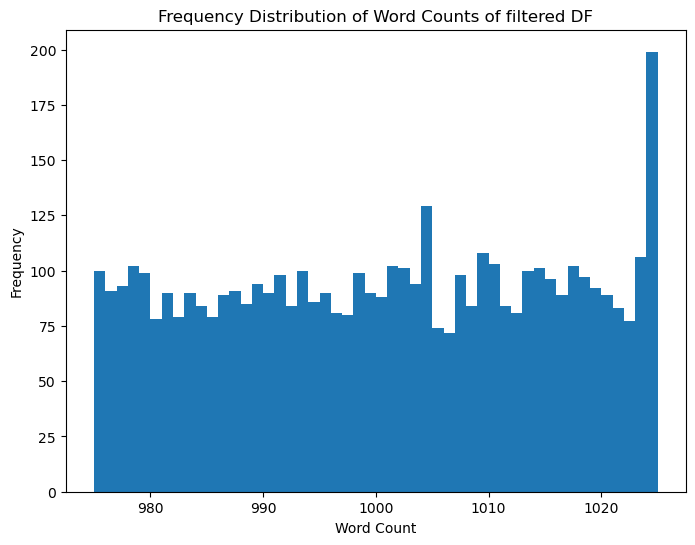

In [60]:
# Set a limit on the maximum word count to be included in the plot
max_word_count = 5000
word_counts = df_filtered[df_filtered['word_count'] <= max_word_count]['word_count']

# Plot frequency distribution of word counts
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(word_counts, bins=50)
ax.set_title('Frequency Distribution of Word Counts of filtered DF')
ax.set_xlabel('Word Count')
ax.set_ylabel('Frequency')
plt.show()

In [62]:
import ast

# Convert string representation of lists to actual lists
df_filtered['tags'] = df_filtered['tags'].apply(lambda x: ast.literal_eval(x))

# Flatten the nested tag lists
tags = [tag for tags in df_filtered['tags'] for tag in tags]

print(tags)


['Sustainability', 'Health', 'Medicine', 'Future', 'Healthcare', 'Writing', 'Psychology', 'Self Improvement', 'Fear', 'Self-awareness', 'Society', 'Technology', 'Future', 'Science', 'Election 2020', 'Productivity', 'Careers', 'Wisdom', 'Entrepreneurship', 'Neuroscience', 'Business', 'Startup', 'Marketing', 'Entrepreneurship', 'Digital Marketing', 'Feathersjs', 'Development', 'Data Engineering', 'AWS', 'Docker', 'Health', 'Happiness', 'Mental Health', 'Self', 'Psychology', 'Architecture', 'Design', 'Industry', 'Entrepreneurship', 'Science', 'Freelancing', 'Nonfiction', 'Writing', 'Marketing', 'Self', 'Marketing', 'Business', 'Creativity', 'Personal Development', 'Writing', 'Headline Hacks', 'Business', 'Productivity', 'Creativity', 'Writing', 'Creativity', 'Productivity', 'Habits', 'Ninjabyob', 'Writing', 'Science', 'Data Science', 'Health', 'Coronavirus', 'Women', 'Writing', 'Mental Health', 'Health', 'Motherhood', 'Mapping', 'Weather', 'Plotly', 'Climate Change', 'Data Visualization',

/var/folders/00/d2rtv3d50bg4lk8kjxc_wybc0000gn/T/ipykernel_91646/915399558.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(top_tags.index, rotation=90, ha='right')


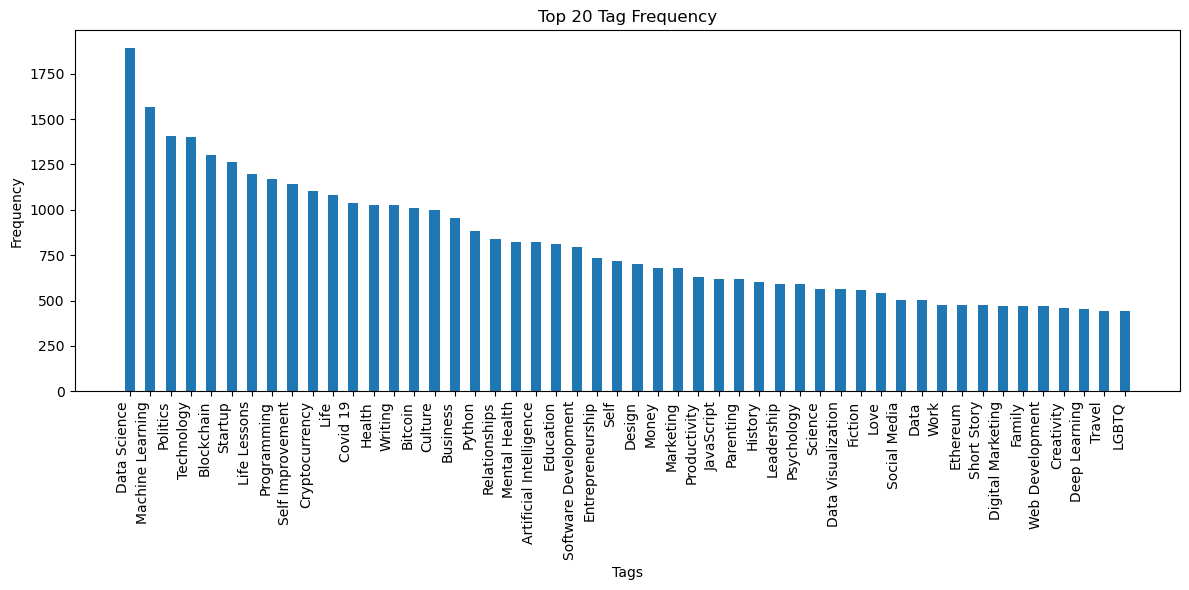

In [63]:
# Create a pandas series of the tag counts
tag_counts = pd.Series(tags).value_counts(normalize=True)

# Get the top 20 tags and their frequency
top_tags = tag_counts.head(50)
top_tags_freq = (top_tags * len(df))

# Filter out tags that occur very infrequently
tag_counts = tag_counts[tag_counts >= 0.001]

# Create the frequency plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(top_tags.index, top_tags_freq, width=0.5)
ax.set_xticklabels(top_tags.index, rotation=90, ha='right')
ax.set_title('Top 20 Tag Frequency')
ax.set_xlabel('Tags')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()


In [64]:
df_filtered['text'][0]

'Dr. Chris Meinzen is a hospitalist at St. Mary’s Hospital in Grand Junction, Colorado. He earned his bachelor’s degree in creative writing and neuroscience at Tulane University in New Orleans, followed by working at the Red Cross, and eventually by medical school also at Tulane.\n\nHow did you decide to go to medical school?\n\nI was a little bumbling at that age. I liked school, enjoyed learning, and had some good friends going in that direction. My family encouraged me to try it out, and here I am 10 years later.\n\nDid you consider other healthcare or public health tracks?\n\nI didn’t, but mostly due to lack of exposure. I think the larger impact of public health is really interesting. I’m not sure I had ever really considered other healthcare tracks, though there are a lot to look at for sure. The physical and occupational therapists always seem the happiest in the hospitals. Maybe I should’ve thought more about that.\n\nWhat was your medical school application experience like?\n\

#### selecting topics

I am worried about selecting random topics, as those aren't necessarily topics tha would be covered by students. How many high schoolers are writing essays about data science after all? So I am going to try to implement topic select, looks like there are enough entries in:

- History
- Psychology
- Science
- Business
- Marketing
- Politics
etc.

Those are common school age topics


In [68]:
topic1 = "History"
topic2 = "Psychology"
topic3 = "Science"
topic4 = "Business"
topic5 = "Marketing"
topic6 = "Politics"

topics = [topic1, topic2, topic3, topic4, topic5, topic6]
df_topics = df_filtered[df_filtered["tags"].apply(lambda x: bool(set(x) & set(topics)))]


### taking random titles and generating essays based on those titles

openai just released their 3.5 turbo model, and it is faster and cheaper, so we're using that here.  The syntax can be found here: https://openai.com/blog/introducing-chatgpt-and-whisper-apis (you need to scroll down and find the code block under ChatGPT API, then click the 'Python bindings' tab)

In [74]:
number_samples = 10

sample = df_topics.sample(number_samples).copy()
sample.head()

titles = sample['title']


In [16]:
import os
import openai
api_key = os.getenv("OPENAI_API_KEY")
print(type(api_key))
#print(api_key)

<class 'str'>


In [32]:
i=0
responses = pd.DataFrame()

for title in titles:
    message = {"role": "user", "content": f"Write a 500 word essay like a college student based on the following title: {title}"}
    completion = openai.ChatCompletion.create(
        model="gpt-3.5-turbo", 
        messages=[message]#,
        #temperature=0.5,
        #max_tokens=500
    )
    response = completion["choices"][0]["message"]["content"]
    responses.loc[i, "response"] = response
    responses.loc[i, "title"] = title
    i += 1


print(responses)


                                            response  \
0  \n\nVisual Storytelling: How it Engages and In...   
1  \n\nAs a successful writer, I am often asked a...   
2  \n\nWhich Payment Methods Should You Accept?\n...   
3  \n\nIn recent times, the world has been making...   
4  \n\n3D modeling is a powerful tool used by man...   
5  \n\nWith the Democratic presidential primaries...   
6  \n\nBarre With Sarah: A Fun and Effective Way ...   
7  \n\nOver the past few years, Bitcoin prices ha...   
8  \n\nHardware prototyping is an essential proce...   
9  \n\nThe Cold War E01: Why did the Cold War sta...   

                                           title  
0                           Visual Story Telling  
1             Confessions of a successful writer  
2       Which Payment Methods Should You Accept?  
3                            4-Bit Deep Learning  
4               Learning 3D modeling in 14 weeks  
5              No, Joe Biden will not move left.  
6                         

#### write dataframe containing responses and titles to an xlsx file

In [35]:
# Write the DataFrame to an Excel file
responses.to_excel("responses.xlsx", index=False)